In [1]:
import pandas as pd
import numpy as np
import os
from IPython.display import display
pd.set_option('display.max_columns', None)
import geopandas as gpd
from shapely import Point, Polygon, MultiPolygon
import contextily as ctx

import mapclassify
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from scipy.spatial import Voronoi
import osmnx as ox
ox.config(log_console=True, use_cache=True)
import pyproj
import math
from tqdm.notebook import tqdm
tqdm.pandas()
from collections import defaultdict

In [2]:
from catboost import CatBoostRegressor, Pool, cv
from sklearn.model_selection import cross_val_score
import copy
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline, make_union
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin, RegressorMixin
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor

In [3]:
from sklearn.neighbors import BallTree
from IPython.display import clear_output

In [4]:
PATH_PROJECT = '..'
PATH_DATA = f'{PATH_PROJECT}/data'
RANDOM_STATE = 42

In [14]:
df = pd.read_pickle(f'{PATH_DATA}/processed/df.pickle')
df_voronoi_features = pd.read_pickle(f'{PATH_DATA}/processed/voronoi_features.pickle')
df_h3 = pd.read_pickle(f'{PATH_DATA}/processed/h3.pickle')
df_top_n = pd.read_pickle(f'{PATH_DATA}/processed/top_n.pickle')
df_pois = pd.read_pickle(f'{PATH_DATA}/processed/df_pois.pickle')
df_stats = pd.read_pickle(f'{PATH_DATA}/processed/stats.pickle')
df_pois_dists = pd.read_pickle(f'{PATH_DATA}/processed/df_pois_dists.pickle')

df = df \
    .merge(df_voronoi_features, on='id', how='left') \
    .merge(df_h3, on='id', how='left') \
    .merge(df_top_n, on='id', how='left') \
    .merge(df_pois, on='id', how='left') \
    .merge(df_stats, on='id', how='left') \
    .merge(df_pois_dists, on='id', how='left')

df['people_voronoi_iso_3_5'] = df.eval('people_voronoi_iso_5-people_voronoi_iso_3')
df['people_voronoi_iso_10_5'] = df.eval('people_voronoi_iso_10-people_voronoi_iso_5')
df['people_voronoi_iso_15_10'] = df.eval('people_voronoi_iso_15-people_voronoi_iso_10')
df['people_voronoi_iso_30_15'] = df.eval('people_voronoi_iso_30-people_voronoi_iso_15')

df['people_voronoi_ratio_3_to_5'] = df.eval('people_voronoi_iso_3 / people_voronoi_iso_10').fillna(1)
df['people_voronoi_ratio_3_to_10'] = df.eval('people_voronoi_iso_3 / people_voronoi_iso_10').fillna(1)
df['people_voronoi_ratio_3_to_15'] = df.eval('people_voronoi_iso_3 / people_voronoi_iso_15').fillna(1)
df['people_voronoi_ratio_3_to_30'] = df.eval('people_voronoi_iso_3 / people_voronoi_iso_30').fillna(1)

df['people_voronoi_ratio_5_to_10'] = df.eval('people_voronoi_iso_5 / people_voronoi_iso_10').fillna(1)
df['people_voronoi_ratio_5_to_15'] = df.eval('people_voronoi_iso_5 / people_voronoi_iso_15').fillna(1)
df['people_voronoi_ratio_5_to_30'] = df.eval('people_voronoi_iso_5 / people_voronoi_iso_30').fillna(1)

df['people_voronoi_ratio_10_to_15'] = df.eval('people_voronoi_iso_10 / people_voronoi_iso_15').fillna(1)
df['people_voronoi_ratio_10_to_30'] = df.eval('people_voronoi_iso_10 / people_voronoi_iso_30').fillna(1)

df['people_voronoi_ratio_15_to_30'] = df.eval('people_voronoi_iso_15 / people_voronoi_iso_30').fillna(1)

df['people_iso_3_5'] = df.eval('people_iso_5-people_iso_3')
df['people_iso_10_5'] = df.eval('people_iso_10-people_iso_5')
df['people_iso_15_10'] = df.eval('people_iso_15-people_iso_10')
df['people_iso_30_15'] = df.eval('people_iso_30-people_iso_15')

In [15]:
df.isna().sum().sort_values(ascending=False).head(5)

sales_per_month        17431
general_dist               0
furniture_shop_dist        0
fountain_dist              0
fort_dist                  0
dtype: int64

In [16]:
df.to_pickle(f'{PATH_DATA}/processed/mart.pickle')

In [17]:
df = pd.read_pickle(f'{PATH_DATA}/processed/mart.pickle')

In [22]:
num_features = ['sales_top_30',  'area_voronoi_iso_10',
 'sales_top_11',  'sales_top_14',  'sales_top_8',
 'voronoi_iso_15_cafe',  'people_voronoi_iso_3',
 'sales_top_2', 'people_iso_10_5',
 'dist_top_10',  'voronoi_iso_15_fast_food',
 'x', 'dist_top_3',  'sales_top_13',
 'people_voronoi_iso_15',  'sales_top_6',
 'voronoi_iso_10_pharmacy',  'voronoi_iso_15_dentist',
 'sales_top_4',  'sales_top_16',
 'sales_top_19',  'dist_top_7',
 'sales_top_23',  'people_iso_3',
 'people_iso_5',  'people_voronoi_iso_30_15',
 'people_iso_15',  'area_iso_15',
 'area_iso_30',  'people_voronoi_iso_5',
 'people_voronoi_ratio_10_to_15',
 'area_iso_10',  'sales_top_29',
 'voronoi_iso_15_pharmacy',
 'ratio_iso_3',  'sales_top_36',
 'ratio_iso_10',  'sales_top_15',
 'sales_top_22',  'sales_top_26',
 'voronoi_iso_15_doctors',  'people_iso_30',  'sales_top_21',
 'area_voronoi_iso_3',  'sales_top_1',
 'people_voronoi_ratio_3_to_5',  'people_iso_10',
 'people_voronoi_ratio_5_to_10',  'dist_top_8',
 'sales_top_17',  'sales_top_10',
 'sales_top_31',  'people_voronoi_ratio_3_to_10',
 'people_voronoi_ratio_15_to_30',
 'sales_top_18',  'voronoi_iso_10_doctors',
 'sales_top_27',  'people_voronoi_iso_15_10',
 'people_voronoi_ratio_3_to_30',  
 'y',  'area_iso_5',  'ratio_iso_30',
 'area_voronoi_iso_15',  'sales_top_35',
 'area_voronoi_iso_30',  'people_voronoi_iso_10_5',
 'sales_top_24',  'sales_top_9',
 'people_voronoi_ratio_5_to_15',  'people_voronoi_ratio_3_to_15',
 'sales_top_32',  'dist_top_1',
 'ratio_iso_5',  'sales_top_5',
 'dist_top_5',  'people_iso_30_15',
 'sales_top_37',  'sales_top_38',
 'sales_top_39',  'sales_top_28',

 'sales_top_25',  'ratio_iso_15',
 'people_voronoi_iso_10',  'people_voronoi_iso_3_5',
 'dist_top_2',  
 'area_voronoi_iso_5',  'people_voronoi_ratio_10_to_30',
 'people_voronoi_iso_30',  'dist_top_6',
 'voronoi_iso_10_dentist',  'dist_top_4',
 'dist_top_9',  'people_iso_15_10',
 'people_voronoi_ratio_5_to_30', 'sales_top_7',
 'sales_top_3', 'sales_top_33',
 'sales_top_12', 'sales_top_20',
                    
                 
                
                
    'region_sales', 'locality_sales',
                
       'ratio_people2area_iso_5', 'ratio_people2area_iso_10',
       'ratio_people2area_iso_15', 'ratio_people2area_iso_30',
                
       'sales_iso_10_top_1', 'sales_iso_10_top_2', 'sales_iso_10_top_3',
       'sales_iso_10_top_4', 'sales_iso_10_top_5', 'sales_iso_10_top_6',
       'sales_iso_10_top_7', 'sales_iso_10_top_8', 'sales_iso_10_top_9',
       'sales_iso_10_top_10', 'sales_iso_10_top_11', 'sales_iso_10_top_12',
       'sales_iso_10_top_13', 'sales_iso_10_top_14', 'sales_iso_10_top_15',
       'sales_iso_10_top_16', 'sales_iso_10_top_17', 'sales_iso_10_top_18',
       'sales_iso_10_top_19',
                
                
                

]

cat_features = ['h3_res_7',
 'h3_res_4',
 'h3_res_6',
 'h3_res_8',
 'locality',
 'country_code',
 'region', 'region_new', 'locality_new', ]

target = 'sales_per_month'

In [23]:
class MyCatBoostRegressorCV(BaseEstimator, RegressorMixin):
            
    def __init__(self, **params):
        self._init_params = params
        self.params = copy.deepcopy(params)
        self.cv = KFold(n_splits=5, random_state=RANDOM_STATE, shuffle=True)
        self.models = []
        self.cat_features = []
        self.score = None
        self.predicts = None
        
    def get_params(self, deep=True):
        return self._init_params
    
    def set_params(self, **params):
        for param, value in params.items():
            self._init_params[param] = value
        self.__init__(**self._init_params)
        return self

    def fit(self, X, y):
        X = X.copy().reset_index(drop=True)
        y = y.copy().reset_index(drop=True)
        self.cat_features = X.columns[X.dtypes == 'O'].tolist()
    
        scores = []
        predict = []
        ids = []
        split = self.cv.split(X)
        for ids_train, ids_test in split:
            
            train = Pool(X.loc[ids_train], y[ids_train], cat_features=self.cat_features)
            test = Pool(X.loc[ids_test], y[ids_test], cat_features=self.cat_features)
            
            model = CatBoostRegressor(**self.params)
            model.fit(train, eval_set=test, verbose=False)

            predict_train = model.predict(train)
            predict_test = model.predict(test)
            score_train = r2_score(train.get_label(), predict_train)
            score_test = r2_score(test.get_label(), predict_test)
            scores.append(score_test)
            predict.append(predict_test)
            ids.append(ids_test)
            print('score_train:', score_train, 'score_test: ', score_test)

            self.models.append(copy.deepcopy(model))
            
        self.score = np.mean(scores)
        ids = np.argsort(np.concatenate(ids))
        self.predicts = np.concatenate(predict)[ids]
        
        return self
       
    def predict(self, X):
        X = Pool(X, cat_features=self.cat_features)
        predict = []
        for model in self.models:
            predict.append(model.predict(X))
        predict = np.mean(predict, axis=0)
        return predict
    
    def get_feature_importance(self):
        return np.vstack([
            model.get_feature_importance(prettified=False) 
            for model in self.models
        ]).mean(axis=0)

In [24]:
mask_train = df['split'] == 'train'
X_train = df.loc[mask_train, num_features+cat_features].reset_index(drop=True)
y_train = df.loc[mask_train, target].reset_index(drop=True)
X_test = df.loc[~mask_train, num_features+cat_features].reset_index(drop=True)

params = {
    'iterations': 2000, # default=500
    'learning_rate': 0.03, # default 0.03
    'task_type': 'GPU',
    'verbose': False,
    'max_depth': 5,
}

model = MyCatBoostRegressorCV(**params)
model.fit(X_train, y_train)

score_train: 0.5078591511231446 score_test:  0.26811759613455655
score_train: 0.5217061575262636 score_test:  0.2567036252071685
score_train: 0.5083389267658354 score_test:  0.27877380243596994
score_train: 0.538487113725064 score_test:  0.3099538528385034
score_train: 0.5043609560616538 score_test:  0.26205316010398605


MyCatBoostRegressorCV(iterations=2000, learning_rate=0.03, max_depth=5,
                      task_type='GPU', verbose=False)

In [25]:
model.score

0.27512040734403687

In [62]:
submission = df.loc[~mask_train, ['id']].copy().reset_index(drop=True)
submission['sales_per_month'] = model.predict(X_test)
submission.to_csv(f'{PATH_DATA}/processed/submission_dima_4.csv', index=False)

In [ ]:
num_features = ['sales_top_30',  'area_voronoi_iso_10',
 'sales_top_11',  'sales_top_14',  'sales_top_8',
 'voronoi_iso_15_cafe',  'people_voronoi_iso_3',
 'sales_top_2', 'people_iso_10_5',
 'dist_top_10',  'voronoi_iso_15_fast_food',
 'x', 'dist_top_3',  'sales_top_13',
 'people_voronoi_iso_15',  'sales_top_6',
 'voronoi_iso_10_pharmacy',  'voronoi_iso_15_dentist',
 'sales_top_4',  'sales_top_16',
 'sales_top_19',  'dist_top_7',
 'sales_top_23',  'people_iso_3',
 'people_iso_5',  'people_voronoi_iso_30_15',
 'people_iso_15',  'area_iso_15',
 'area_iso_30',  'people_voronoi_iso_5',
 'people_voronoi_ratio_10_to_15',
 'area_iso_10',  'sales_top_29',
 'voronoi_iso_15_pharmacy',
 'ratio_iso_3',  'sales_top_36',
 'ratio_iso_10',  'sales_top_15',
 'sales_top_22',  'sales_top_26',
 'voronoi_iso_15_doctors',  'people_iso_30',  'sales_top_21',
 'area_voronoi_iso_3',  'sales_top_1',
 'people_voronoi_ratio_3_to_5',  'people_iso_10',
 'people_voronoi_ratio_5_to_10',  'dist_top_8',
 'sales_top_17',  'sales_top_10',
 'sales_top_31',  'people_voronoi_ratio_3_to_10',
 'people_voronoi_ratio_15_to_30',
 'sales_top_18',  'voronoi_iso_10_doctors',
 'sales_top_27',  'people_voronoi_iso_15_10',
 'people_voronoi_ratio_3_to_30',  
 'y',  'area_iso_5',  'ratio_iso_30',
 'area_voronoi_iso_15',  'sales_top_35',
 'area_voronoi_iso_30',  'people_voronoi_iso_10_5',
 'sales_top_24',  'sales_top_9',
 'people_voronoi_ratio_5_to_15',  'people_voronoi_ratio_3_to_15',
 'sales_top_32',  'dist_top_1',
 'ratio_iso_5',  'sales_top_5',
 'dist_top_5',  'people_iso_30_15',
 'sales_top_37',  'sales_top_38',
 'sales_top_39',  'sales_top_28',

 'sales_top_25',  'ratio_iso_15',
 'people_voronoi_iso_10',  'people_voronoi_iso_3_5',
 'dist_top_2',  
 'area_voronoi_iso_5',  'people_voronoi_ratio_10_to_30',
 'people_voronoi_iso_30',  'dist_top_6',
 'voronoi_iso_10_dentist',  'dist_top_4',
 'dist_top_9',  'people_iso_15_10',
 'people_voronoi_ratio_5_to_30', 'sales_top_7',
 'sales_top_3', 'sales_top_33',
 'sales_top_12', 'sales_top_20',
                    
                 
                
                
    'region_sales', 'locality_sales',
                
       'ratio_people2area_iso_5', 'ratio_people2area_iso_10',
       'ratio_people2area_iso_15', 'ratio_people2area_iso_30',
                
       'sales_iso_10_top_1', 'sales_iso_10_top_2', 'sales_iso_10_top_3',
       'sales_iso_10_top_4', 'sales_iso_10_top_5', 'sales_iso_10_top_6',
       'sales_iso_10_top_7', 'sales_iso_10_top_8', 'sales_iso_10_top_9',
       'sales_iso_10_top_10', 'sales_iso_10_top_11', 'sales_iso_10_top_12',
       'sales_iso_10_top_13', 'sales_iso_10_top_14', 'sales_iso_10_top_15',
       'sales_iso_10_top_16', 'sales_iso_10_top_17', 'sales_iso_10_top_18',
       'sales_iso_10_top_19',
                
                
                
'alpine_hut_dist',
 'archaeological_dist',
 'arts_centre_dist',
 'artwork_dist',
 'atm_dist',
 'attraction_dist',
 'bakery_dist',
 'bank_dist',
 'bar_dist',
 'battlefield_dist',
 'beauty_shop_dist',
 'bench_dist',
 'beverages_dist',
 'bicycle_rental_dist',
 'bicycle_shop_dist',
 'biergarten_dist',
 'bookshop_dist',
 'butcher_dist',
 'cafe_dist',
 'camera_surveillance_dist',
 'camp_site_dist',
 'car_dealership_dist',
 'car_rental_dist',
 'car_sharing_dist',
 'car_wash_dist',
 'caravan_site_dist',
 'castle_dist',
 'chalet_dist',
 'chemist_dist',
 'cinema_dist',
 'clinic_dist',
 'clothes_dist',
 'college_dist',
 'comms_tower_dist',
 'community_centre_dist',
 'computer_shop_dist',
 'convenience_dist',
 'courthouse_dist',
 'dentist_dist',
 'department_store_dist',
 'doctors_dist',
 'dog_park_dist',
 'doityourself_dist',
 'drinking_water_dist',
 'embassy_dist',
 'fast_food_dist',
 'fire_station_dist',
 'florist_dist',
 'food_court_dist',
 'fort_dist',
 'fountain_dist',
 'furniture_shop_dist',
 'garden_centre_dist',
 'general_dist',
 'gift_shop_dist',
 'golf_course_dist',
 'graveyard_dist',
 'greengrocer_dist',
 'guesthouse_dist',
 'hairdresser_dist',
 'hospital_dist',
 'hostel_dist',
 'hotel_dist',
 'hunting_stand_dist',
 'ice_rink_dist',
 'jeweller_dist',
 'kindergarten_dist',
 'kiosk_dist',
 'laundry_dist',
 'library_dist',
 'lighthouse_dist',
 'mall_dist',
 'market_place_dist',
 'memorial_dist',
 'mobile_phone_shop_dist',
 'monument_dist',
 'motel_dist',
 'museum_dist',
 'newsagent_dist',
 'nightclub_dist',
 'nursing_home_dist',
 'observation_tower_dist',
 'optician_dist',
 'outdoor_shop_dist',
 'park_dist',
 'pharmacy_dist',
 'picnic_site_dist',
 'pitch_dist',
 'playground_dist',
 'police_dist',
 'post_box_dist',
 'post_office_dist',
 'prison_dist',
 'pub_dist',
 'public_building_dist',
 'recycling_dist',
 'recycling_clothes_dist',
 'recycling_glass_dist',
 'recycling_metal_dist',
 'recycling_paper_dist',
 'restaurant_dist',
 'ruins_dist',
 'school_dist',
 'shelter_dist',
 'shoe_shop_dist',
 'sports_centre_dist',
 'sports_shop_dist',
 'stadium_dist',
 'stationery_dist',
 'supermarket_dist',
 'swimming_pool_dist',
 'telephone_dist',
 'theatre_dist',
 'theme_park_dist',
 'toilet_dist',
 'tourist_info_dist',
 'tower_dist',
 'town_hall_dist',
 'toy_shop_dist',
 'track_dist',
 'travel_agent_dist',
 'university_dist',
 'vending_any_dist',
 'vending_cigarette_dist',
 'vending_machine_dist',
 'vending_parking_dist',
 'veterinary_dist',
 'video_shop_dist',
 'viewpoint_dist',
 'waste_basket_dist',
 'wastewater_plant_dist',
 'water_mill_dist',
 'water_tower_dist',
 'water_well_dist',
 'water_works_dist',
 'wayside_cross_dist',
 'wayside_shrine_dist',
 'windmill_dist',
 'zoo_dist',
]

cat_features = ['h3_res_7',
 'h3_res_4',
 'h3_res_6',
 'h3_res_8',
 'locality',
 'country_code',
 'region', 'region_new', 'locality_new', ]

target = 'sales_per_month'

In [20]:
mask_train = df['split'] == 'train'
X_train = df.loc[mask_train, num_features+cat_features].reset_index(drop=True)
y_train = df.loc[mask_train, target].reset_index(drop=True)
X_test = df.loc[~mask_train, num_features+cat_features].reset_index(drop=True)

params = {
    'iterations': 2000, # default=500
    'learning_rate': 0.03, # default 0.03
    'task_type': 'GPU',
    'verbose': False,
    'max_depth': 5,
}

model = MyCatBoostRegressorCV(**params)
model.fit(X_train, y_train)

score_train: 0.5331956762888446 score_test:  0.2402705203132276
score_train: 0.5396728855742644 score_test:  0.24988079116304518
score_train: 0.5446469903705006 score_test:  0.2747738231984588
score_train: 0.5700395307644102 score_test:  0.27732055981427484
score_train: 0.5326072940190199 score_test:  0.2410968655721858


MyCatBoostRegressorCV(iterations=2000, learning_rate=0.03, max_depth=5,
                      task_type='GPU', verbose=False)

небольшой анализ предсказаний

In [65]:
df_train = df[mask_train]
df_train['predict'] = model.predicts

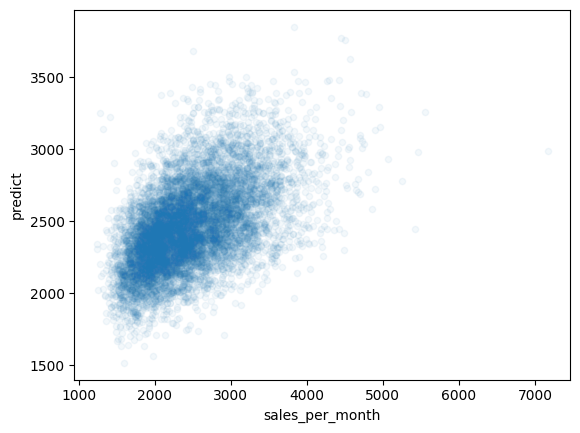

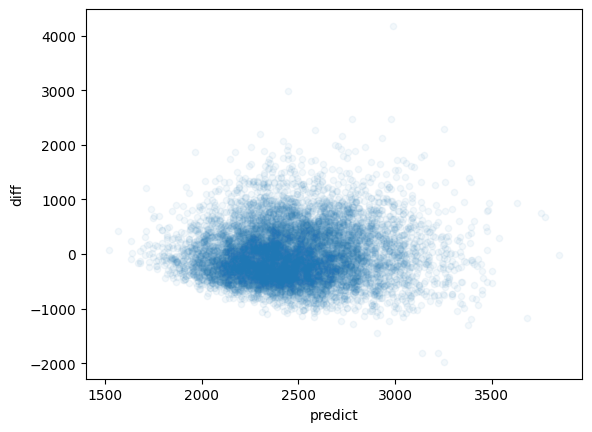

In [66]:
df_train[['sales_per_month','predict']].plot.scatter(x='sales_per_month', y='predict', alpha=0.05)
df_train['diff'] = df_train.eval('sales_per_month - predict')
df_train.plot.scatter(x='predict', y='diff', alpha=0.05);

In [83]:
df_train \
    .groupby('region_new')[['sales_per_month', 'predict']] \
    .agg(list) \
    .apply(lambda x: r2_score(*x), axis=1) \
    .sort_values(ascending=False) \
    .head(40)

region_new
Брестская область                  0.495490
Ульяновская область                0.463497
Гомельская область                 0.420722
Свердловская область               0.380015
Санкт-Петербург                    0.348748
Мурманская область                 0.340573
Республика Хакасия                 0.337662
Республика Марий Эл                0.324628
Хабаровский край                   0.322643
Республика Тыва                    0.315683
Республика Алтай                   0.315591
Новгородская область               0.315343
Волгоградская область              0.315005
Камчатский край                    0.312816
Челябинская область                0.310577
Липецкая область                   0.309110
Минская область                    0.308310
Иркутская область                  0.305315
Алтайский край                     0.305053
Ленинградская область              0.304712
Тюменская область                  0.300849
Чеченская Республика               0.300686
Приморский край      

In [84]:
df_train \
    .groupby('locality_new')[['sales_per_month', 'predict']] \
    .agg(list) \
    .apply(lambda x: r2_score(*x), axis=1) \
    .sort_values(ascending=False) \
    .dropna() \
    .head(40)

locality_new
Брест                   0.475337
Улан-Удэ                0.461882
Уссурийск               0.447634
Гагарин                 0.440260
Долгопрудный            0.427348
Тольятти                0.419649
Вологда                 0.413215
Могилёв                 0.396375
Ульяновск               0.395724
Комсомольск-на-Амуре    0.384918
Нижний Тагил            0.375323
Сергиев Посад           0.373728
Тюмень                  0.367848
Екатеринбург            0.365678
Челябинск               0.353071
Владимир                0.348515
Северодвинск            0.345696
Армавир                 0.343346
Наро-Фоминск            0.341963
Мурманск                0.340573
Барнаул                 0.338007
Санкт-Петербург         0.333313
Новокузнецк             0.329433
посёлок Шушары          0.328786
Ноябрьск                0.328360
Тверь                   0.320809
Курск                   0.318087
Ногинск                 0.317210
Липецк                  0.314319
Евпатория               0.3127

In [85]:
df_train \
    .groupby('locality_new')[['sales_per_month', 'predict']] \
    .agg(list) \
    .apply(lambda x: r2_score(*x), axis=1) \
    .sort_values(ascending=False) \
    .dropna() \
    .tail(40)

locality_new
Ижевск                0.149649
Ростов-на-Дону        0.145827
Череповец             0.145540
Реутов                0.141532
Сочи                  0.140241
Сыктывкар             0.135238
Ялта                  0.134544
Орехово-Зуево         0.134520
Саранск               0.133404
Чита                  0.127171
Петрозаводск          0.125702
Мытищи                0.124757
Одинцово              0.121411
Оренбург              0.120488
Чехов                 0.118614
Кемерово              0.111353
Анапа                 0.110359
Севастополь           0.101368
Пенза                 0.100169
Астана                0.088217
Белгород              0.073072
Керчь                 0.072901
Старый Оскол          0.065208
Орёл                  0.058721
Ангарск               0.058547
Щербинка              0.058118
Братск                0.046374
посёлок Коммунарка    0.045977
Йошкар-Ола            0.045297
Витебск               0.039061
Люберцы               0.036462
Благовещенск          0.02

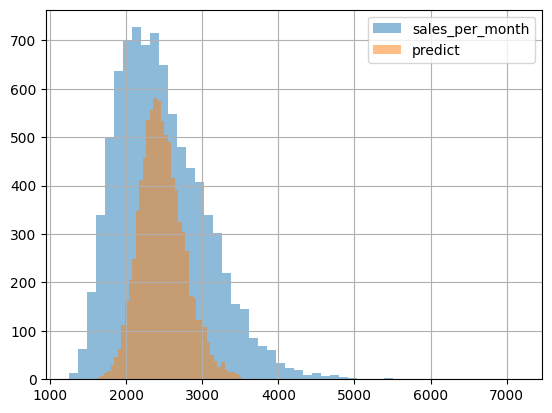

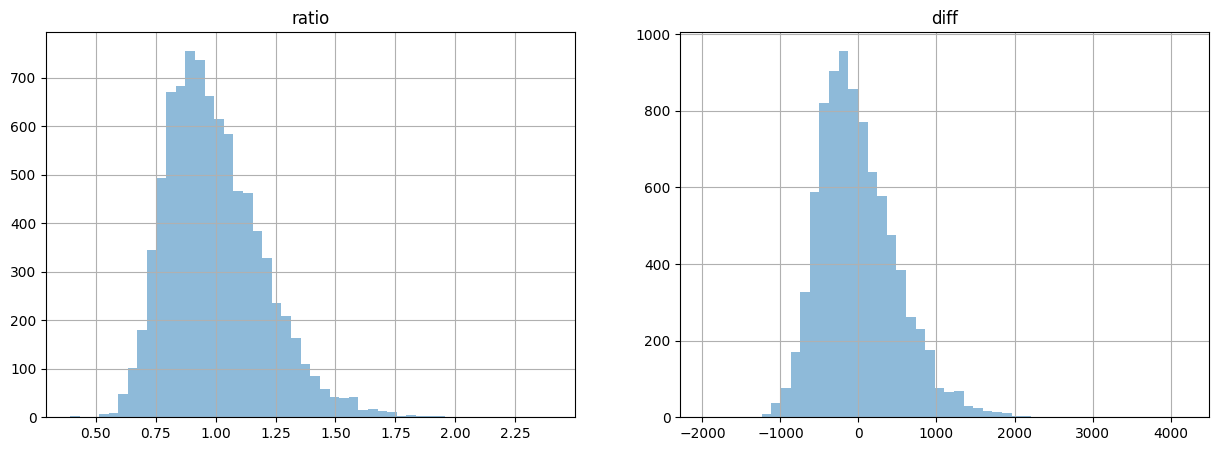

In [86]:
df_train['sales_per_month'].hist(bins=50, label='sales_per_month', alpha=0.5)
df_train['predict'].hist(bins=50, label='predict', alpha=0.5)
plt.legend()
plt.show()

fig, axes = plt.subplots(1,2, figsize=(15,5))
df_train.eval('sales_per_month / predict').hist(bins=50, alpha=0.5, ax=axes[0])
axes[0].set_title('ratio')
df_train.eval('sales_per_month - predict').hist(bins=50, alpha=0.5, ax=axes[1])
axes[1].set_title('diff')
plt.show()

In [75]:
df_voronoi = pd.read_pickle(f'{PATH_DATA}/processed/df_voronoi.pickle')

Тюмень


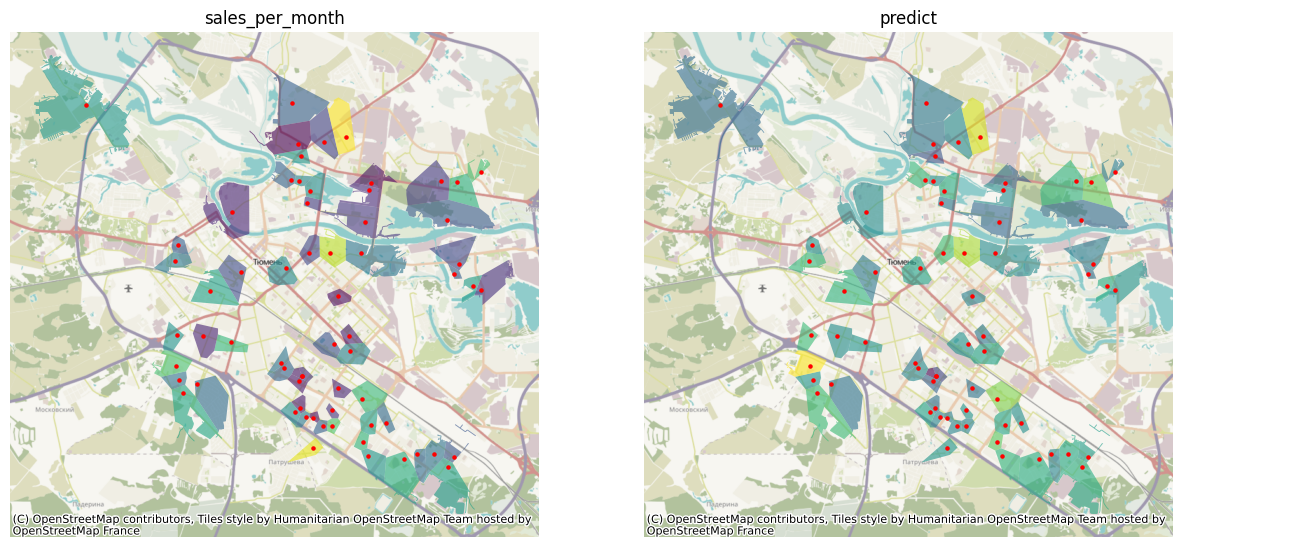

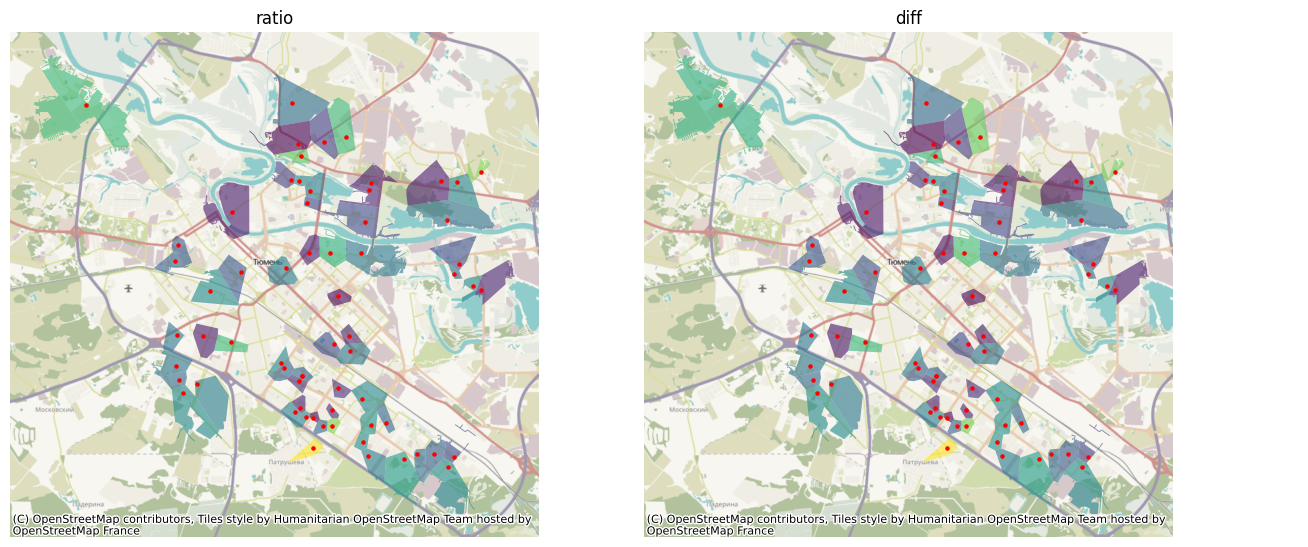

In [89]:
locality = 'Тюмень'

tmp = df_train.query('locality == @locality')[['sales_per_month','predict', 'id']] \
    .merge(df_voronoi[['id', 'voronoi_iso_30', 'point']], on='id')
tmp['ratio'] = tmp.eval('sales_per_month / predict')
tmp['diff'] = tmp.eval('sales_per_month - predict')

voronoi = gpd.GeoDataFrame(tmp.copy(), geometry=tmp['voronoi_iso_30'], crs=4326).to_crs(3857)
point = gpd.GeoDataFrame(tmp.copy(), geometry=tmp['point'], crs=4326).to_crs(3857)

print(locality)

fig, axes = plt.subplots(1,2, figsize=(15,15))

voronoi.plot(column='sales_per_month', ax=axes[0], alpha=0.6)
mymap = point.plot(ax=axes[0], markersize=5, color='r')
axes[0].set_title('sales_per_month')
ctx.add_basemap(mymap, url='http://a.tile.openstreetmap.org/{z}/{x}/{y}.png')
axes[0].set_axis_off()

voronoi.plot(column='predict', ax=axes[1], alpha=0.6)
mymap = point.plot(ax=axes[1], markersize=5, color='r')
axes[1].set_title('predict')
ctx.add_basemap(mymap, url='http://a.tile.openstreetmap.org/{z}/{x}/{y}.png')
axes[1].set_axis_off()

plt.show()

fig, axes = plt.subplots(1,2, figsize=(15,15))

voronoi.plot(column='ratio', ax=axes[0], alpha=0.6)
mymap = point.plot(ax=axes[0], markersize=5, color='r')
axes[0].set_title('ratio')
ctx.add_basemap(mymap, url='http://a.tile.openstreetmap.org/{z}/{x}/{y}.png')
axes[0].set_axis_off()

voronoi.plot(column='diff', ax=axes[1], alpha=0.6)
mymap = point.plot(ax=axes[1], markersize=5, color='r')
axes[1].set_title('diff')
ctx.add_basemap(mymap, url='http://a.tile.openstreetmap.org/{z}/{x}/{y}.png')
axes[1].set_axis_off()

plt.show()

Гродно


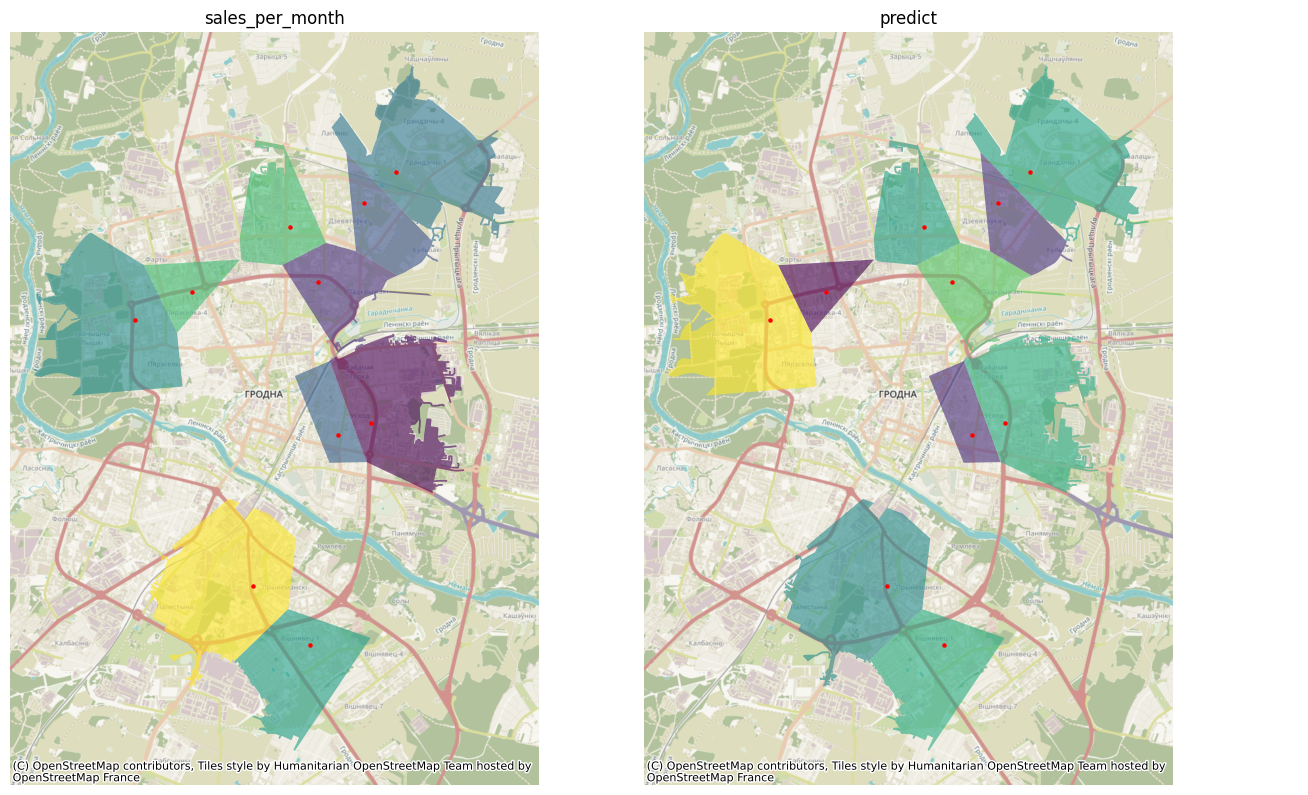

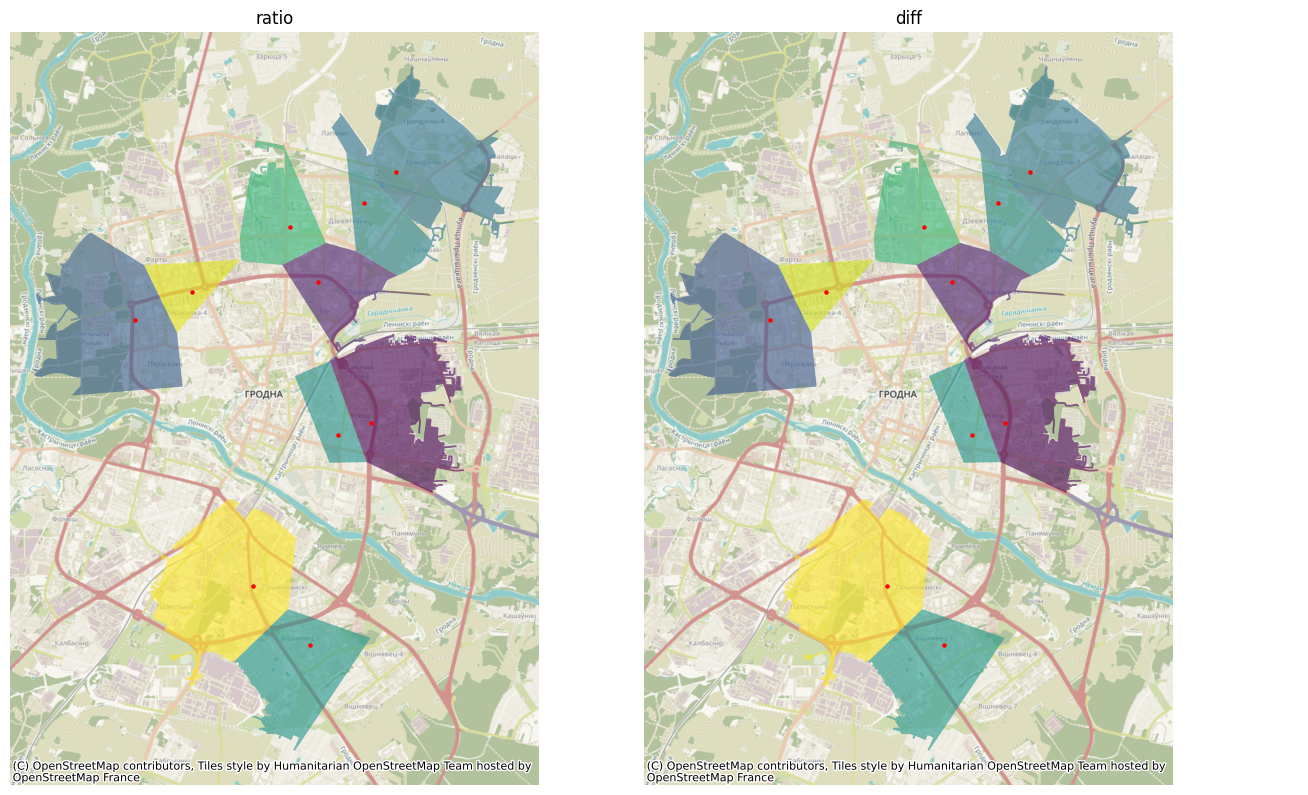

In [90]:
locality = 'Гродно'

tmp = df_train.query('locality == @locality')[['sales_per_month','predict', 'id']] \
    .merge(df_voronoi[['id', 'voronoi_iso_30', 'point']], on='id')
tmp['ratio'] = tmp.eval('sales_per_month / predict')
tmp['diff'] = tmp.eval('sales_per_month - predict')

voronoi = gpd.GeoDataFrame(tmp.copy(), geometry=tmp['voronoi_iso_30'], crs=4326).to_crs(3857)
point = gpd.GeoDataFrame(tmp.copy(), geometry=tmp['point'], crs=4326).to_crs(3857)

print(locality)

fig, axes = plt.subplots(1,2, figsize=(15,15))

voronoi.plot(column='sales_per_month', ax=axes[0], alpha=0.6)
mymap = point.plot(ax=axes[0], markersize=5, color='r')
axes[0].set_title('sales_per_month')
ctx.add_basemap(mymap, url='http://a.tile.openstreetmap.org/{z}/{x}/{y}.png')
axes[0].set_axis_off()

voronoi.plot(column='predict', ax=axes[1], alpha=0.6)
mymap = point.plot(ax=axes[1], markersize=5, color='r')
axes[1].set_title('predict')
ctx.add_basemap(mymap, url='http://a.tile.openstreetmap.org/{z}/{x}/{y}.png')
axes[1].set_axis_off()

plt.show()

fig, axes = plt.subplots(1,2, figsize=(15,15))

voronoi.plot(column='ratio', ax=axes[0], alpha=0.6)
mymap = point.plot(ax=axes[0], markersize=5, color='r')
axes[0].set_title('ratio')
ctx.add_basemap(mymap, url='http://a.tile.openstreetmap.org/{z}/{x}/{y}.png')
axes[0].set_axis_off()

voronoi.plot(column='diff', ax=axes[1], alpha=0.6)
mymap = point.plot(ax=axes[1], markersize=5, color='r')
axes[1].set_title('diff')
ctx.add_basemap(mymap, url='http://a.tile.openstreetmap.org/{z}/{x}/{y}.png')
axes[1].set_axis_off()

plt.show()